In [1]:
!pip install transformers

     |████████████████████████████████| 778kB 8.1MB/s 
     |████████████████████████████████| 3.0MB 22.7MB/s 
     |████████████████████████████████| 1.1MB 51.6MB/s 
     |████████████████████████████████| 890kB 49.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=8162132839c4915c50c296e023284ffd433d1985ea615c204e5c30a40b795441
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import torch
import transformers
# per the setting of transformers, to use any of its NLP model
# we need to have three things: that is BertTokenizer, BertModel, BertConfig
from transformers import BertTokenizer, BertModel, BertConfig

In [3]:
# first, let's see if we have GPU so that we could train our model in GPU
# GPU is really at parallel computation
from torch import cuda
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(device)


cuda


In [ ]:
# collect Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

In [5]:
# create an instance of BERT model 
# note that it takes time to download the BERT model (~ 440M)
# BERT model is big, because it has a lot of paramters. 
model = BertModel.from_pretrained('bert-base-uncased')

In [6]:
# creat an instance of BERT tokenizer
# as you can tell, the tokenizer is pretty small, only 232k in size
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/lizhyde5/RPA_Project/master/16K_AmazonReviews.csv'
raw_review = pd.read_csv(url)
raw_review

,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,social_connectedness,environment,self_sufficiency,transparency_authenticity,tradition,individuality,diversity_equality,privacy,status,thrift_value,innovation,fun_adventure,health
0,BOSS HUGO BOSS Men's Starfish Swim Trunk,Apparel,4,0,0,N,N,Good quality,"The quality is good, fits good but I didnt pay...",6/23/2014,0,0,0,0,0,1,0,0,0,1,0,0,0
1,Vedette Megane Firm Compression Sensual Corset...,Apparel,4,1,2,N,Y,I like this bodyshaper.,This body shaper does what it says. It makes y...,9/1/2013,0,0,0,0,0,1,0,0,0,1,0,0,1
2,Adult Stilinski 24 Beacon Hills Lacrosse 2-Sid...,Apparel,5,0,0,N,Y,Nice hoodie,It looks well made. I bought it for my grandda...,8/3/2015,1,0,0,0,0,0,0,0,0,1,0,0,0
3,Carhartt Men's Sherpa Lined Sandstone Hooded M...,Apparel,5,3,3,N,Y,Size Small Means Medium,Other than the sizing that is bigger than the ...,10/2/2014,0,0,0,0,0,0,0,0,1,1,0,0,1
4,Roxy Juniors Gallery Backpack,Apparel,5,0,0,N,Y,Five Stars,Love my backpack.,9/15/2014,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656,Virus Removal Service - Jupiter Support,Software,5,0,0,N,N,IE issue,i just got done with jupiter on i script prob ...,4/26/2014,0,0,0,0,0,0,0,0,0,1,0,0,0
1657,Family Tree Maker 2011 Deluxe [Old Version],Software,3,1,2,Y,N,Not for use on a netbook,I used this software on my netbook and it divi...,9/23/2011,0,0,0,0,0,0,0,0,0,1,0,0,0
1658,"Learn Italian: Fluenz Italian 1 for Mac, PC, i...",Software,5,2,2,N,N,awesome program,"hi, Just want to say it what a great company! ...",4/30/2010,0,0,0,0,0,0,0,0,0,1,0,0,0
1659,Kaspersky Internet Security 2009 (3 User),Software,5,0,0,N,Y,Great product,Great internet security product. I guess the b...,12/22/2008,0,0,0,0,0,0,0,0,0,1,0,0,0


In [8]:
raw_review.iloc[398,:]

product_title                      Women's Combed Cotton Rib-Knit Thermal Vest
product_category                                                       Apparel
star_rating                                                                  1
helpful_votes                                                                0
total_votes                                                                  0
vine                                                                         N
verified_purchase                                                            Y
review_headline                    Women's Combed Cotton Rib-Knit Thermal Vest
review_body                  it is not like it looks in the image!<br />i d...
review_date                                                         11/23/2012
social_connectedness                                                         0
environment                                                                  0
self_sufficiency                                    

In [9]:
train_review = pd.DataFrame(None)

train_review[['text','label']] = raw_review[['review_body','thrift_value']].iloc[0:1661,:]



In [10]:
train_review = train_review.dropna()

In [11]:
train_review.describe()

,label
count,1660.000000
mean,0.792771
std,0.405443
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


# Define a Customized Dataset Class and Setup the Dataloader



In [12]:
# first let's define some key parameters we will use later
# note this is a relatively large number, making the training process slow, 
# but it's necessary becuase a lot of reviews are long.
max_length = 128
# how many raw inputs we feed into the train and validation model at once
train_batch = 32
valid_batch = 32



In [13]:
# then we need to import the libraries we need
import numpy as np
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [14]:
class YelpDataset(Dataset):

  # here we want to  create a customized dataset--YelpDataset--which could take a raw text as input
  # and encode it in BERT's way with a tokenizer. 
  # The tokenized input will be then fed into a BERT Model in the NN, which we will create later

  # __init__ defines some necessary attributes for any instance created
  # like: the dataset with raw text reviews, what tokenizer we want to use for encoding, 
  # the max length of sentence we need to pad or trancate
  def __init__(self, dataset, tokenizer, max_len):
    self.tokenizer = tokenizer
    self.data = dataset
    self.text = dataset.text
    self.label = dataset.label
    self.max_len = max_len
  

  def __len__(self):
    return len(self.text)


  def __getitem__(self, index):
    # __getitem__ take index as input, 
    # in general/without customizatin, it returns the sample with the index in the dataset
    # further we could customize its functionality, letting it to apply some operations on the 
    # index-specified sample before return a value for us
    # here we use index to locate a specific review text we want to pre-process
    # text = str(self.text[index])
    # text = " ".join(text.split())
    text = self.text.iloc[index]

    # then, we put the text into a BERT encode_plus
    # important debug tips: 
    # for encode_plus, to keep all the raw inputs in the same lenght
    # we need to specify BOTH padding and trancation in addition to max_length
    # the former for short sentences and the latter for long ones
    # failing to do either one will result in uneven lengths of encoded inputs,
    # which will create troubles for your dataloader in the nn training sessions
    outputs = self.tokenizer.encode_plus(
        text,
        max_length = self.max_len,
        padding = "max_length",
        truncation = "longest_first",
        # note that in some versions of transformer in you local machine, the code is 
        # pad_to_max_length = True,
        # truncation_strategy = 'longest_first',
        # we might need to change the argument name a little to fit different version of transformers
        add_special_tokens = True,
        return_tensors = 'pt'
    )
    # recall the BERT Tokenizer session, it takes raw text as input
    # and return input_ids, attention_mask
    input_ids = outputs['input_ids']
    attention_mask = outputs['attention_mask']
    # we then store those values and put them together with the label info in the sample
    # as the return of the __getitem__ method
    return {
        'input_ids': torch.tensor(input_ids, dtype = torch.long),
        'attention_mask': torch.tensor(attention_mask, dtype = torch.long),
        'label': torch.tensor(self.label.iloc[index], dtype = torch.float) 
    }



In [15]:
# split the train and validate dataset
from sklearn.model_selection import train_test_split
train_raw, valid_raw = train_test_split(train_review, test_size = 0.1)

In [16]:
# create instances of the YelpDataset for raw trianing and validate datasets
# recall that tokenizer has be defined by: tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') in the BERT tokenizer session
train_processed = YelpDataset(train_raw, tokenizer, max_length)
valid_processed = YelpDataset(valid_raw, tokenizer, max_length)

In [17]:
# check the attributes and method of train_processed
train_processed.__len__()

1494

In [18]:
# test the customized Dataset instance
print(train_processed.__getitem__(10))

{'input_ids': tensor([[  101,  2023,  4007,  2573,  2004,  3517,  1012,  2026,  3274,  2038,
          1996,  4185,  2978, 13151,  1025,  2061,  1045,  2134,  1005,  1056,
          2031,  1996,  3291,  2060,  3080,  6097,  3274,  5608, 10865,  2055,
          1012,  1012,  1012,  1045,  5993,  1010,  2027,  2323,  2031,  2070,
          2828,  1997,  2200,  5793,  5432,  2055, 11303,  1996,  6745, 18017,
          2000,  2224,  2023,  4007,  1012,  2026,  2069, 12087,  2003,  1012,
          1012,  1012,  2205,  2116,  3980,  2055,  2477,  2008,  2134,  1005,
          1056,  6611,  2000,  2033,  1998,  2644,  2667,  2000,  5271,  2033,
          4933,  1999,  1996,  2690,  1997,  2667,  2000,  2131,  2083,  1996,
          5409,  2112,  1997,  2026,  2095,   999,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [19]:
# see the dimension of the pre-processed data
print(train_processed.__getitem__(10)['input_ids'].shape)
# we can use the squeeze() method to remove the axis of "1", a method we will use later
print(train_processed.__getitem__(10)['input_ids'].squeeze().shape)

torch.Size([1, 128])
torch.Size([128])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [20]:
# important, run it again to create a new dataset loader for every NN model you train
# lastly, set up the dataloader that serves as a pipeline feeding pre-processed data into the neural network
train_sampler = RandomSampler(train_processed)
train_loader = DataLoader(train_processed, batch_size = train_batch, num_workers = 0)
valid_sampler = SequentialSampler(valid_processed)
valid_loader = DataLoader(valid_processed, batch_size = valid_batch, num_workers = 0)

In [21]:
# exploer the attributes of dataloder
# length of dataloader = len(dataset)/batch size
print(len(train_loader))
print(len(valid_loader))


47
6


# Define a Customized Neural Network with the First Hidden Layer as NLP Encoding Layer


Up to now, we have defined the customized Dataset class that preprocess the raw input, encoding them into input_ids and attention_mask that BERT model needs. We also set up the Dataloader that feed the pre-processed data into the Neural Network we are creating now. 

In [22]:
# import the functions we need use in the Netwrok Model
import torch.nn.functional as F

In [23]:
# the neural network we create is a class called  YelpBERT, which inherits
# the attributes and structures of the torch.nn.Module

# the __init__ functino defines the necessary hidden layers of the NN
# and the forward function set up the computation graph: the real calculation procedures of the NN
# see the class session 7's slides and recording for details 

class YelpBERT(torch.nn.Module):
  def __init__(self):
    super(YelpBERT, self).__init__()
    # recall that, we have defined model as: model = BertModel.from_pretrained('bert-base-uncased')
    # see BERT Model's input and output: https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    self.l1 = model

    # with this layer a percentage of all neurons will be randomly turned-off to prevent overfitting
    # since our training dataset might be small, we really cannot afford a large neural network
    # the output of the BERT layer is a vector of 768 elements, if fully connected to next linear layer
    # then the current layer would have 768 neurons, too much! 
    # using dropout mechanism, we can randomly turn off a percentage of the neuraon in the training process
    # literally reduced the number of neuron in the layer
    self.l2 = torch.nn.Dropout(0.3) 

    # if you want to have multiple fully connected linear layer, use this
    # self.l2 = torch.nn.Linear(768, 10)
    # but again, if your training dataset is not very large, we may only offard one linear layer
    
    # last layer
    self.l3 = torch.nn.Linear(768, 1)


  
  def forward(self, input_ids, attention_mask):
    # first layer
    # the first layer utilize the BERT model (call "model" in __init__) to transfer the input_ids into
    # contextualized word embeddings --numerical vectors
    # we can customize the output of this layer such as using the [CLS] token or the mean of all input tokens
   
    # if you want to use the BERT output of the last self-attention layer, use this:
    last, pooler = self.l1(input_ids = input_ids, attention_mask = attention_mask)
   
    # if you want to use BERT output from OTHER self-attention layers,use this:
    # (note that BERT base model has 12 hidden self-attention layers), 
    # last, pooler, all = self.l1(input_ids = input_ids, attention_mask = attention_mask, output_hidden_states = True)
    
    # second layer
    # here we could use the mean value of tokens of all raw inputs as the embedding of the whole input text
    # and feed it into the second layer, use this: 
    # output from last BERT self-attention layer:
    # initial index "0" for mean value of [cls] token and all non-padded tokens
    # initial index "1" for mean value of all non-padded tokens only
    output = last[:, 0 : attention_mask.sum(), :].mean(dim = 1)
    # BERT output from other hidden self-attention layer:
    # output = all[11][:, 0 : attention_mask.sum(), :].mean(dim = 1)
    
    # or use the [CLS] token of last layer
    # output = last[:, 0, :]

    # output from BERT model now be fed into a relu activation funcation adn
    # the second layer of the Neural Network
    output = F.relu(output.squeeze())
    output = F.relu(self.l2(output))

    # why squeeze(): to make the dimension of input-output across layers consistent
    # e.g., the output of layer 1--self.l1, is in the shape of (1, 768),
    # we use .squeeze() to make it in a shape of (768) only, 
    # because the later layer--l2 adn l2--take (768) as input dimension not (1, 768)

    # third layer
    output = self.l3(output)

    # last sigmoid layer to furhter transfer the single scalar of l3 into a probability
    return torch.sigmoid(output)
    # note that we can also customize the layers after the 1st one, 
    # making more layers (i.e., a deeper NN) and see if it perform betters 

In [24]:
# test the model step-by-step
# compare the output dimension to your expectation
# https://huggingface.co/transformers/model_doc/bert.html#bertmodel
# testing each layer in the NN is very important
# we should pay close attention the the dimensions of the inputs and outputs of each layer 
# use .squeeze() to remove uncessary axis whose length is 1 to make the dimensions consistent. like "output = pooler.squeeze()" in the NN above
l1 = model
l1.to(device)
input_ids = train_processed.__getitem__(10)['input_ids'].to(device)
attention_mask = train_processed.__getitem__(10)['attention_mask'].to(device)
last, pooler = l1(input_ids = input_ids, attention_mask = attention_mask)
print(last.shape)
print(last.squeeze().shape)
print(pooler.shape)
print(pooler.squeeze().shape)

torch.Size([1, 128, 768])
torch.Size([128, 768])
torch.Size([1, 768])
torch.Size([768])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [25]:
# similarly, test if the dimensions of input and output 
output = last[:, 1 : attention_mask.sum(), :].mean(dim = 1)
output = output.squeeze()
output.shape
l2 = torch.nn.Dropout(0.5)   
l2.to(device)
l3 = torch.nn.Linear(768, 1)
l3.to(device)
output.to(device)
l3(l2(torch.tensor(output)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


tensor([0.4963], device='cuda:0', grad_fn=<AddBackward0>)

# Create a BERT + NN Model as an Instance of the Customized Model Classs Defined Above and Setup the Loss Function and Optimizer


In [26]:
# create an instance of the YelpBERT model
# remember to recreat a instance of the Model Class after you modified the YelpBERT class
model_yelp = YelpBERT()
model_yelp.to(device)

YelpBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [27]:
# test the model_yelp
# recall that the train_processed is a special class that could pre-process the raw input words into input_ids
# and attentino_mask using its method __getitem__ method
# we then use this method to get the input_ids and attention_mask that we need to feed in the YelpBERT() model

test_output = model_yelp(input_ids, attention_mask)
print(len(test_output))
print(test_output)
# note that the output is a scalar, becasue ofthe last hidden layer in the NN, self.l3 = torch.nn.Linear(768, 1)
# the scalar then can be put into a softmax for prediction 


1
tensor([0.5529], device='cuda:0', grad_fn=<SigmoidBackward>)


In [28]:
print(input_ids.shape)
print(attention_mask.shape)


torch.Size([1, 128])
torch.Size([1, 128])


In [29]:
# check out the model parameters
# note that the first BERT layer, the word embeddings are in the shape of (30522, 768)
# and we can tell that the first 12 layers of our model are normal BERT layers, 
# the last two are what we customized-- a dropout layer and the linear layer
model_yelp.parameters

<bound method Module.parameters of YelpBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Up to now, we have the Dataset (pre-process/encode the raw text inputs, making them into input_ids that BERT model takes as input), the Dataloader (feed the processed data into the NN in batchs), the neural network (with the first layer as a BERT model, the transfer the encoded input_ids into word embeddings, and later layers just work on those embeddings/numerical vectors as normal neural network). 

And finally, we could set up our training loops

First we start with: the loss function (e.g., crossentropy loss or mean squared error loss) and the optimize schedule (some thing about learning rate, adaptive learning rate, see class 7)

In [30]:
import torch.nn as nn
import torch.optim as optim

In [31]:
# criterion is the loss function we use
# here we use Binary CrossEntropy Loss, you can try others see the performance difference
# https://pytorch.org/docs/master/generated/torch.nn.BCELoss.html
criterion = nn.BCELoss()
# note that loss function in pytorch framework usually take the pair of (prediction, ground_truth) as input
# and give the loss value as output

In [32]:
# optimizer is our optimize strategy, here we use stachastic gradient descending as the approch 
# to update our model parameters. 
# tips: previously I trained multiple models but with learning rate = 1e-05, 3e-05, 
# after 4 epochs the model performance almost doesn't change
# thus now I use 10e-05, it seems the performance improves faster
learning_rate = 10e-05
# SGD is a common optimizer, but let's use Adam here, AdamW is a optimizer developed by Huggingface using Adam's mechanism
# optimizer = optim.SGD(model_yelp.parameters(), lr = learning_rate, momentum = 0.9)
# http://deeplearning.stanford.edu/tutorial/supervised/OptimizationStochasticGradientDescent/
# you can try out other optimization method and see performance difference

In [33]:
# set the epoch
epochs = 5
# epochs means how many rounds each training sample will be fed into the NN.
# next, we need to supply our model "model_yelp" to the GPU, so it can be run on GPU
# model_yelp.to(device)
# since the GPU has a lot of cores, it takes some time to supply to model to the GPU


In [34]:
# try another optimizer
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model_yelp.parameters(),lr = learning_rate,eps = 1e-8)
                  
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler that update the learning rate gradully, this scheduler is with AdamW
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [35]:
# lastly, let's define a helper function we can use for calculating the prediction accuracy
import numpy as np
# the idea of the funtion is that a vector of predicted probablity of being good review, 
# which is the output of the sigmoid/last layer of the neural network, is compared with the true label
# is the predicted probability >= 0.5, we assign 1, otherwise we assign 0, we use np.around() achieve this
def pred_accuracy (prediction, label):
  pred_flat = np.around(prediction).flatten()
  label_flat = label.flatten()
  return np.sum(pred_flat == label_flat) / len(label_flat)


# Train the BERT + NN Model and Evaluate the Performance

In [36]:
# set the random set the same, making the results reproducible
import random
seed_val = 45
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

OK, finally, we strat to train the model

In [37]:
# create an instance of the YelpBERT model
model_yelp = YelpBERT()
model_yelp.to(device)

YelpBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [38]:
# set up the directory for storing the trained model
import os
# save to Google Drive
dir = "/content/drive/My Drive"
# save to local file
# dir = "E://OneDrive - lmu.edu//Python Projects//BERT and ML"


In [39]:
# Very Important: Each Time When You Train a Neural Network Again, 
# Plase recreate the nural network, the dataloader, and the optimizer and its scheduler.


# train the model 
# store the total loss and accuracy values of each epoch
training_stats = []

# the epoch loop, number of rounds specified by epochs
for epoch_i in range(0, epochs):
  print('======== Epoch {:} / {:} =========='.format(epoch_i + 1, epochs))
  # zero the values of total loss and accuracy of the epoch
  total_loss = 0
  total_accuracy = 0
  # in the training stage, set the model into train mode
  model_yelp.train()

  # the training step loop
  # recall that train_loader feed data into the NN in batchs to save memory and improve efficiency
  # then the # of total steps is about (# of samples/batch size)
  print("training")
  for step, batch in enumerate(train_loader, 0):
    # feed the data into GPU using .to(device) method
    # note that the input_ids for one raw input is in the shape of (1, max_length)
    # after be processed into batch, the input_ids become (batch_size, 1, max_length)
    # however, BERT only takes input_ids in the shape of (batch_size, max_length),
    # (see here: https://huggingface.co/transformers/model_doc/bert.html#bertmodel)
    # so we need to do "batch['input_ids'].squeeze()" inestead of "batch['input_ids']"
    # to remove the unnecessy axis of "1". 
    # same operation for attention_mask
    input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
    label = batch['label'].to(device, dtype = torch.float)

    # at each step, before the NN does the feed forward, let's set the gradient to 0
    # as pytorch nn.Module automatically cumulates gradient from previous rounds
    # this is good for RNN training, but not necessy for us here. Thus, we turn it off.   
    optimizer.zero_grad()
    
    # for each raw input, the feed forward calculation give us two scalar, 
    # representing the score/probability of the sample being 0/bad review class or 1/good review class  
    # note that since we feed the inputs/raw samples in batch, 
    # the prediciton should be in the shape of (batch_size, # of classes)
    prediction = model_yelp(input_ids, attention_mask)
    prediction = prediction.squeeze()

    # criterion is defined as a cross entropy loss function
    # it takes (prediction, ground truth) as input arugments
    # the former should be in the shape of (batch_size, # of classes), 
    # the latter should be in the sahpe of (batch_szie, 1), "1" dimension records the true class id of the input
    # https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html   
    loss = criterion(prediction, label)

    # with the loss, we can do back propagation to calculate the gradient
    # very easy, just one line of code  
    loss.backward()

    # with the gradient, we can update the model paramters. 
    # recall how we define the optimizer in the above cell  
    optimizer.step()
    
    # update the learning rate
    scheduler.step()

    # to keep tracking on the model performance, we accumulate the total loss in every epoch  
    total_loss += loss.item()
      
    # for every 10 steps, we print out the epoce # and loss
    # again, the max_length of raw text input is 256, relatively long than usual, thus it will take longer to train. 
    if step%10 == 0 and step != 0:
      print(f'Epoch:{epoch_i + 1}, Total_Loss:{total_loss}, Average_Loss:{total_loss/step}')
  
  # calcualte and store the average training loss of each batch in the current epoch
  avg_train_loss = total_loss / len(train_loader)

  

  # now let's set up the validation loop, meaning the trained model above will be used to evaluate the sample in validation dataset
  # note that this validation loop is in the same "indent" level as the training loop, and they both under the epoches loop
  print("validating")
  # set the model now in the evaluation mode
  model_yelp.eval()
  # zero the values of total loss and accuracy
  total_loss = 0
  #total_accuracy = 0

  # validation loop
  for step, batch in enumerate(valid_loader, 0):
    input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
    label = batch['label'].to(device, dtype = torch.float)

    with torch.no_grad():
        prediction = model_yelp(input_ids, attention_mask)
        prediction = prediction.squeeze()
        loss = criterion(prediction, label)

    total_loss += loss.item()

    if step%10 == 0 and step != 0:
      print(f'Epoch:{epoch_i + 1}, Total_Loss:{total_loss}, Average_Loss:{total_loss/step}')

  # calcualte and store the average training loss of each batch in the current epoch
  avg_valid_loss = total_loss / len(valid_loader)

  training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_valid_loss
        }
    )
  


  # lastly, at the end of each epoch, let's save the model for later use
  # note that dir is defined before as "./content/drive/My Drive"  
  #torch.save(model_yelp.state_dict(), os.path.join(dir, 'exper-epoch-{}.pt'.format(epoch_i)))

print("training complete!")



======== Epoch 1 / 5 ==========
training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:1, Total_Loss:5.717357844114304, Average_Loss:0.5717357844114304
Epoch:1, Total_Loss:10.19218823313713, Average_Loss:0.5096094116568566
Epoch:1, Total_Loss:14.514244019985199, Average_Loss:0.4838081339995066
Epoch:1, Total_Loss:18.685896456241608, Average_Loss:0.4671474114060402
validating
======== Epoch 2 / 5 ==========
training
Epoch:2, Total_Loss:4.527608245611191, Average_Loss:0.4527608245611191
Epoch:2, Total_Loss:7.812741816043854, Average_Loss:0.39063709080219267
Epoch:2, Total_Loss:10.6848354190588, Average_Loss:0.35616118063529334
Epoch:2, Total_Loss:13.257733196020126, Average_Loss:0.3314433299005032
validating
======== Epoch 3 / 5 ==========
training
Epoch:3, Total_Loss:3.042593702673912, Average_Loss:0.3042593702673912
Epoch:3, Total_Loss:4.724332839250565, Average_Loss:0.23621664196252823
Epoch:3, Total_Loss:6.150029171258211, Average_Loss:0.2050009723752737
Epoch:3, Total_Loss:7.762863051146269, Average_Loss:0.19407157627865673
validating
======== Epoch 4 / 5 ======

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


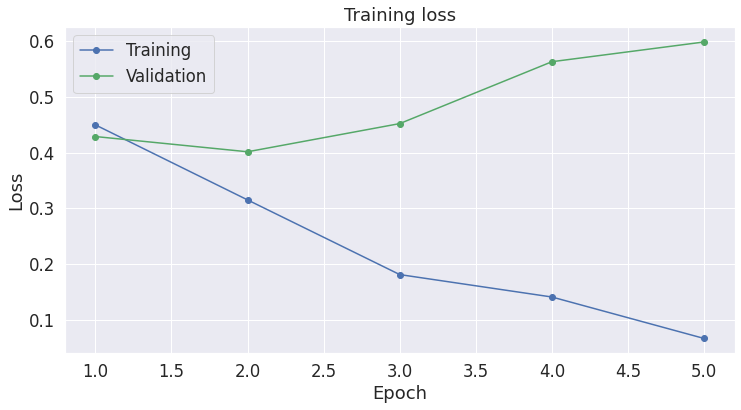

In [40]:
# plot the train statistics stored in training_stats
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "darkgrid")

sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = [12, 6]

df_stats = pd.DataFrame(data = training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [42]:
# make sure to save the model performance statistics and the associated model configuration. 
# that is save the df_stats to csv file with a file name, say experiment 1
df_stats.to_csv(os.path.join(dir, 'label_experiment_3.csv'))
# save the key hyper-parameters of this training experiment, say experiment 1
label_experiment_3_config = {
    "epochs": epochs,
    "train_batch_size" : train_batch,
    "valid_batch_size" : valid_batch,
    "initial_learning_rate": learning_rate,
     "max_sentence_length": max_length,
     "loss_fucntion": criterion,
     "optimizer": optimizer,
     # you need to manually type-in the following info
     "BERT output": "mean value of [cls] embeddings of non-padded token from the second to the last layer",
     "activation function": "relu",
     "dropout rate of BERT output": model_yelp.l2,
     "# of fully connected linear layer": 1,
     "dataset": "Yelp Review Balanced",
     "comment": "sees not as good as the outputs of last layer"
}


In [43]:
# save the experiment configurate assocaited with this experiment
# note that if you click the file icon (the third vertical one on the far left)
# you will see the save files, double click on them, you can see them.
import csv
with open(os.path.join(dir, 'label_experiment_3_config.csv'), 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in label_experiment_3_config.items():
       writer.writerow([key, value])

# Evaluate the Model Performance

In [44]:
# apply the trained model to the validation dataset
# get the model predictions and compare the comparisons to the true labels
model_yelp.eval()
predictions, labels = [], []
for step, batch in enumerate(valid_loader):
  input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
  attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
  label = batch['label'].to('cpu').numpy()
  
  with torch.no_grad():
    prediction = model_yelp(input_ids, attention_mask)

  prediction = prediction.detach().cpu().numpy()
  predictions.append(prediction)
  labels.append(label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [45]:
# call the helper function-- pred_accuacy to compute the prediction accuracy in each batch
ac = []
for i in range(len(predictions)):
  ac_i = pred_accuracy(predictions[i], labels[i])
  ac.append(ac_i)
ac

[0.875, 0.71875, 0.75, 0.71875, 0.75, 1.0]

In [46]:
# transfer the outcomes into np
predictions = np.asarray(predictions)
labels = np.asarray(labels)
predictions[0]
# note that now the outcomes are still stored in batches

array([[0.99265796],
       [0.9876747 ],
       [0.99289566],
       [0.99269426],
       [0.9926508 ],
       [0.9905719 ],
       [0.99278545],
       [0.9929536 ],
       [0.9928954 ],
       [0.9909887 ],
       [0.4444267 ],
       [0.19371367],
       [0.9923666 ],
       [0.98878354],
       [0.99281436],
       [0.99255824],
       [0.9912839 ],
       [0.9920758 ],
       [0.98625517],
       [0.9925021 ],
       [0.9892869 ],
       [0.9923145 ],
       [0.93370634],
       [0.9921808 ],
       [0.992331  ],
       [0.9925418 ],
       [0.992841  ],
       [0.99295205],
       [0.9908262 ],
       [0.1422755 ],
       [0.992448  ],
       [0.87144285]], dtype=float32)

In [47]:
# convert predictions stored in the batches into a long vector
pred = np.concatenate(predictions, axis=0 )
pred = np.concatenate(pred, axis=0 )
pred = pred.reshape(len(pred),1)
print(pred.shape)

(166, 1)


In [48]:
# convert the true labels batches into a long vector
true_label = np.concatenate(labels, axis=0 )
true_label = true_label.reshape(len(true_label), 1)
print(true_label.shape)
type(true_label)

(166, 1)


numpy.ndarray

In [49]:
# put the predictions and labels into the same dataset
df = np.concatenate([pred, true_label], axis = 1)
df = pd.DataFrame(data=df, columns=["preds", "labels"])
df

,preds,labels
0,0.992658,1.0
1,0.987675,1.0
2,0.992896,1.0
3,0.992694,1.0
4,0.992651,1.0
...,...,...
161,0.992830,1.0
162,0.992942,1.0
163,0.992491,1.0
164,0.992022,1.0


In [50]:
# see the total prediction accuracy
sum((df["preds"]>=0.5) == df["labels"])

128

In [51]:
# find the index of the review that has the lowest predicted probabilty(of being a positive review) in true_label == 1 group. 
df.loc[df.loc[df['labels'] == 1, :].idxmin()]

,preds,labels
42,0.022807,1.0
0,0.992658,1.0


In [52]:
# see that review
valid_raw.iloc[19,0]


'very cute and quality is great!'

In [53]:
# alternatively, for all the reviews that have true_label == 1, 
# let's sort their predicted probabilities
df.loc[df['labels'] == 1, :].sort_values('preds')

,preds,labels
42,0.022807,1.0
47,0.029856,1.0
107,0.030506,1.0
102,0.032977,1.0
67,0.091342,1.0
...,...,...
162,0.992942,1.0
117,0.992945,1.0
27,0.992952,1.0
7,0.992954,1.0


In [54]:
df[df['labels']==1].preds.sort_values()[0:20]

42     0.022807
47     0.029856
107    0.030506
102    0.032977
67     0.091342
29     0.142275
51     0.286563
64     0.287584
110    0.365407
37     0.416454
10     0.444427
98     0.609578
131    0.632105
136    0.719472
115    0.923206
92     0.924024
22     0.933706
126    0.935800
58     0.949276
106    0.964320
Name: preds, dtype: float32

In [55]:
# see the reviews
valid_raw.iloc[23,0]

"comes in handy, but the rewind is a bit awkward and doesn't seem to fit right."

In [56]:
# on the other way around, for all the reviews whose label == 0, 
# let's sort their predicted probablities in descending order
df[df['labels'] == 0].sort_values('preds', ascending = False)

,preds,labels
6,0.992785,0.0
68,0.992730,0.0
158,0.992493,0.0
101,0.992321,0.0
66,0.991955,0.0
157,0.991892,0.0
154,0.990968,0.0
86,0.988661,0.0
99,0.988312,0.0
149,0.982794,0.0


In [57]:
# see the reviews
# after learning some examples, it seems that our model will give a high score as long as the food is good
# even though the service is not. 
valid_raw.iloc[26,0]

"I got this program for free with my Visor Edge, and although it was a great freebie the Edge already came with a datebook the was equally as good as this one. Still for the time I had it, it worked great and didn't give me any problems while transfering my addresses and other pieces of data from my computer to my handheld. So I recomend this to someone who has an old PDA that doesn't have a great datebook."